In [2]:
#!pip install openai
#!pip install tiktoken
#!pip install itables

In [3]:
# get OpenAI API secret
import os

if os.getenv("COLAB_RELEASE_TAG"):
  # env variable for Google Collab
  from google.colab import userdata
  OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
else:
  # env variable locally
  !source ~/.zprofile
  import os
  OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')


In [4]:
# defining and testing openAI connexion
import openai
client = openai.OpenAI(api_key=OPENAI_API_KEY)

completion = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Hello!"}
  ]
)

print(completion.choices[0].message.content)

Hello! How can I assist you today?


# scripts to automatically label sampled review via chatGPT

- asking `gpt-3.5-turbo` to add a label for each review
- we are not batching reviews yet bc : 
  - the prompt is relatively short, so repeating it it not too expansive
  - gpt 3.5 tend to be less accurate in case of large context

In [5]:
import numpy as np
import pandas as pd
import data_loader
import tiktoken
import time
from itables import show

def build_full_prompt(review, prompt):
  messages = [
    {"role": "system", "content": prompt},
    {"role": "user", "content": review}
  ]
  return messages


# estimating prompt costs

def num_tokens_from_messages(messages, model="gpt-3.5-turbo-0613"):
  """Returns the number of tokens used by a list of messages."""
  # from open AI doc: https://platform.openai.com/docs/guides/text-generation/managing-tokens
  try:
      encoding = tiktoken.encoding_for_model(model)
  except KeyError:
      encoding = tiktoken.get_encoding("cl100k_base")
  if model == "gpt-3.5-turbo-0613":  # note: future models may deviate from this
      num_tokens = 0
      for message in messages:
          num_tokens += 4  # every message follows <im_start>{role/name}\n{content}<im_end>\n
          for key, value in message.items():
              num_tokens += len(encoding.encode(value))
              if key == "name":  # if there's a name, the role is omitted
                  num_tokens += -1  # role is always required and always 1 token
      num_tokens += 2  # every reply is primed with <im_start>assistant
      return num_tokens
  else:
      raise NotImplementedError(f"""num_tokens_from_messages() is not presently implemented for model {model}.
  See https://github.com/openai/openai-python/blob/main/chatml.md for information on how messages are converted to tokens.""")


def estimate_prompt_cost(dataset, prompt):
  input_cost_per_million = 0.5 # USD
  output_cost_per_million = 1.5 # USD

  # tokens estimation for each review in the dataset
  dataset.reviews_df['prompt tokens'] = dataset.reviews_df['review'].apply(lambda r: num_tokens_from_messages(build_full_prompt(r, prompt)))

  prompt_tokens = num_tokens_from_messages(build_full_prompt(" ", prompt))
  avg_input_tokens_per_review =  dataset.reviews_df['prompt tokens'].mean()
  total_input_tokens = dataset.reviews_df['prompt tokens'].sum()
  total_input_cost = total_input_tokens/ 1000000 * input_cost_per_million
  

  # print stats
  print('for {} reviews:'.format(dataset.reviews_df.shape[0]))
  print('\t- tokens for the prompt iteslf:', prompt_tokens)
  print('\t- avg token per full prompt (1 per review):', avg_input_tokens_per_review)
  print("\t- total nb of input tokens :", total_input_tokens)
  print("\t- estimated cumulated cost of prompts {} $".format(total_input_cost))
  print("\t- (cost of generated tokens are not estimated)")

  return total_input_cost


# ask chat GPT to output labels for a given a instruction/prompt

def fetch_review_label(review, prompt):
  """
  ask chat GPT to output label(s)
  for a single review for a given a instruction/prompt
  """

  completion = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=build_full_prompt(review, prompt)
  )
  chatgpt_label = completion.choices[0].message.content
  prompt_tokens = completion.usage.prompt_tokens
  completion_tokens = completion.usage.completion_tokens

  return chatgpt_label, prompt_tokens, completion_tokens


def fetch_dataset_labels(dataset, prompt):
  """
  ask chatGPT to ouput label(s)
  for a whole dataset for a given a prompt
  """
    
  dataset.reviews_df[['chatgpt_label', 'prompt tokens', 'completion tokens']] = np.nan # reset topics or create columns

  def get_label_and_save_output(x):
      x['chatgpt_label'], x['prompt tokens'], x['completion tokens'] = fetch_review_label(x['review'], prompt)
      return x
  dataset.reviews_df = dataset.reviews_df.apply(get_label_and_save_output, axis=1)

  return dataset   


def apply_prompt(dataset, prompt):
  """
  apply the prompt to the dataset with costs check and display some stats
  """
  # check cost
  total_input_cost = estimate_prompt_cost(dataset, prompt)

  # ask for confirmation
  print('Please check cost and confirm request. Waiting for your input...')
  answer = input("/!\ This will cost at least {} $. \n Continue? (y, yes, ok)".format(total_input_cost))

  if answer.lower() not in ["y","yes","ok"]:
    print(' WARNING : Request cancelled.')
    return
  else:
    print('Asking ChatGPT...')
    
    # fetch labels for the provided dataset
    start_time = time.time()
    dataset = fetch_dataset_labels(dataset, prompt)
    duration = time.time() - start_time

    avg_duration = duration/dataset.reviews_df.shape[0]
    print("Took {:.2f} seconds ({:.2f} s on avg per review)".format(duration ,avg_duration ) )

    return dataset


In [6]:
# testing the script with basic topics and prompt
topics = {
    "Problème d'abonnement": "Lorsqu'un client a des difficultés à résilier un abonnement, ou a télécharge un produit numérique.",
    "Problème d'expédition ou de stock": "Lorsqu'une commande est envoyée très en retard ou annulée par manque de stock.",
    "Problème de livraison": "Lorsqu'une commande a été reçue en retard par rapport à la date estimée, a demandé plusieurs tentatives de livraison, ou lorsque le livreur n'a pas suivi les instructions de livraison.",
    "Commande jamais reçue": "Lorsqu'une commande n'a jamais été reçue par le client ou n'a pas été livrée.",
    "Produit reçu cassé" : "Lorsqu'un des produits commandés est reçu cassé, abîmé, endommagé.",
    "Suspicion de vol": "Lorsque le coli est reçu sans produit à l'intérieur ou bien un produit qui n'a absolument rien à voir (ex: un sac de farine au lieu d'un téléphone).",
    "Produit défectueux": "Lorsque le produit reçu est le bon mais ne fonctionne pas comme attendu, est défectueux ou dysfonctionnel.",
    "Contrefaçon": "Lorsque le produit reçu ressemble au produit commandé mais ne correspond pas à la description, est une contrefaçon ou une imitation.",
    "Panne": "Lorsque le produit reçu est tombé en panne ou s'est cassé après une certaine période d'utilisation qui semble trop courte."
}

prompt = f"""
Your task is to classify the following negative ecommerce wenbsite reviews into one of the topics listed in this json structure: {topics}
Each topic is described with the instruction of when it should apply.
Respond with the different topic that apply to each review, in the format of a python list: ["Topic_1", "Topic_2"]
If no topic seems to match enough, respond with an empty python list: [].
"""
dataset = data_loader.Data(sample_size=5)
dataset = apply_prompt(dataset, prompt)

with pd.option_context('display.max_colwidth', None):
      display(dataset.reviews_df[['review','chatgpt_label']])


for 5 reviews:
	- tokens for the prompt iteslf: 450
	- avg token per full prompt (1 per review): 624.0
	- total nb of input tokens : 3120
	- estimated cumulated cost of prompts 0.00156 $
	- (cost of generated tokens are not estimated)
Please check cost and confirm request. Waiting for your input...
Asking ChatGPT...
Took 3.81 seconds (0.76 s on avg per review)


,review,chatgpt_label
96621,"aucun sérieux, sav à la ramasse, et beaucoup trop de problèmes avec les articles, bref à fuir ! je retourne sur amazon c'est un plus cher mais au moins je me ferais pas n*quer jusqu'à l'os là bas","[""Problème d'expédition ou de stock"", ""Produit défectueux""]"
96235,"achat d'un aspirateur balai 2 en 1 bosch le 24/01/2017 sur le site cdiscount, depuis le 05 mars il ne fonctionne plus , il est garanti . cdiscount en est informé mais rien comme j'habite en haute corse il n'y a pas de sav bosch , j'appelle tous les 2 jours au 3979 mais on me dit qu'on traite mon dossier !!!! enfin , je commandais sur ce site maintenant fini , le sav et service client sont incompétents et franchement quand aprés on va sur les forums on s’aperçoit que l'on est beaucoup à avoir des problèmes suite à des pannes chez CDISCOUNT , SITE A EVITER",['Panne']
56190,Si je pouvais mettre zero je le mettrai. Commande d'un frigo pour être livré le jeudi 23/07( journée posé pour la livraison). Paiement autorisé et je vois ma commande sur mon compte Cdiscount mais 5 jours plus tard je m'inquiète un peu car je ne reçois pas de confirmation de commande et sur mon compte je ne vois plus ma commande. Je me dis c'est peut-être un beug. Ha mais c'est bizarre mon paiement a été autorisé mais rien de débité. Donc j'appelle avec la plus grande sympathie (car je connais le sens du commerce MOI) la première personne me dit que votre commande est annulée plutôt mais la deuxième au téléphone très désagréable alors que je demande juste qu'on m'envoie un mail ou une preuve que ma commande est bien annulée car j'ai aucune preuve. '' ha non nous faisons pas de mail et on a un problème informatique rappeler plus tard'' l'a j'ai toujours rien j'ai peu d'en commander un autre dans un autre commerce bien sûr et men faire débiterchez eux sans aucun moyen de leur prouvé qu'il m'ont dit que ma commande était annulé.,"[""Commande jamais reçue""]"
4211,"Pendant des années, je commandais sur Amazon sans problème et en toute confiance. Un jour, je constate qu'un vendeur était en train d'utiliser mon compte pour me vendre des sacs, super moches et hors de prix. Du coup, je supprime ma carte et je passe un bon moment à chater avec leur service client, qui me disent qu'ils ne peuvent rien faire et qu'il faut annuler mes commandes (ce que j'avais fait bien entendu). Mais le vendeur n'en a tenu aucun compte et a quand même basculé mes commandes en statut ""expédié"". De nouveau, je contacte Amazon, furieuse, en leur demandant de bloquer les paiements. Réponse : non, ils paient quand même l'escroc, mais pas d'inquiétude, ma banque me remboursera. Malgré plusieurs signalements comme quoi ce vendeur était malhonnête et piratait des comptes pour passer des commandes fictives, Amazon n'a rien fait. Donc, pour moi, maintenant, c'est terminé. Méfiez-vous, si vous vous faites avoir sur ce site, vous n'aurez aucun soutien de leur part, ils comptent sur les assurances des banques.","[""Suspicion de vol""]"
55285,"Bonjour, Tout simplement des escrocs, je n'ai jamais reçu ma commande sois disant livré. J'ai signé un document sur l'honneur que je n'ai rien reçu mais ni de remboursement ni de colis. Je les ai contacter plus de 20 fois.... ensuite je ne lache rien je rappelle on me dit désolé votre réclamation n'est plus valable, le délai est écoulé. Donc ce site a bannir que des problème.","[""Commande jamais reçue"", ""Problème de livraison""]"


# basic evaluations of chatGPT labelling

To facilitate iteration on the prompts and the labels, a few methods to get a few stats

checking for : 
- hallucinations % : is the label in the prompt or made up?
- no label % : how much it was ok to not label a review

In [45]:
import ast

def check_for_hallucinated_labels(labelled_dataset, topics):
    def count_hallinated_label(r):
        hallucinations_nb  = 0
        try:
            predicted_labels = ast.literal_eval(r['chatgpt_label'])
            if len(predicted_labels) > 0:
                for l in predicted_labels:
                    if l not in topics.keys():
                        hallucinations_nb += 1
            r['hallucinated labels count'] = hallucinations_nb
        except SyntaxError:
            r['hallucinated labels count'] = 1 # if label is not parsable, it's hallucinated
        return r
    
    labelled_dataset.reviews_df = labelled_dataset.reviews_df.apply(count_hallinated_label, axis=1)
    pct_hallucinated =  labelled_dataset.reviews_df['hallucinated labels count'].astype(bool).sum(axis=0) / labelled_dataset.reviews_df.shape[0]

    print('eval - proportion of reviews with hallucinated label(s):', pct_hallucinated )

    return labelled_dataset, pct_hallucinated


def check_for_no_label(labelled_dataset):

    pct_no_label = labelled_dataset.reviews_df[labelled_dataset.reviews_df['chatgpt_label']=='[]'].shape[0] / labelled_dataset.reviews_df.shape[0]

    print('eval - proportion of reviews with no label:', pct_no_label )

    return labelled_dataset, pct_no_label



    

In [49]:
# testing the script with basic topics and prompt

topics = {
    "Problème d'abonnement": "Lorsqu'un client a des difficultés à résilier un abonnement, ou a télécharge un produit numérique.",
    "Problème d'expédition ou de stock": "Lorsqu'une commande est envoyée très en retard ou annulée par manque de stock.",
    "Problème de livraison": "Lorsqu'une commande a été reçue en retard par rapport à la date estimée, a demandé plusieurs tentatives de livraison, ou lorsque le livreur n'a pas suivi les instructions de livraison.",
    "Commande jamais reçue": "Lorsqu'une commande n'a jamais été reçue par le client ou n'a pas été livrée.",
    "Produit reçu cassé" : "Lorsqu'un des produits commandés est reçu cassé, abîmé, endommagé.",
    "Suspicion de vol": "Lorsque le coli est reçu sans produit à l'intérieur ou bien un produit qui n'a absolument rien à voir (ex: un sac de farine au lieu d'un téléphone).",
    "Produit défectueux": "Lorsque le produit reçu est le bon mais ne fonctionne pas comme attendu, est défectueux ou dysfonctionnel.",
    "Contrefaçon": "Lorsque le produit reçu ressemble au produit commandé mais ne correspond pas à la description, est une contrefaçon ou une imitation.",
    "Panne": "Lorsque le produit reçu est tombé en panne ou s'est cassé après une certaine période d'utilisation qui semble trop courte."
}

prompt = f"""
Your task is to classify the following negative ecommerce website reviews into one of the topics listed in this json structure: {topics}
Each topic is described with the instruction of when it should apply.
Respond with the different topic that apply to each review, in the format of a python list: ["Topic_1", "Topic_2"]
If no topic seems to match enough, respond with an empty python list: [].
"""

dataset = data_loader.Data(sample_size=5)
dataset = apply_prompt(dataset, prompt)

dataset, pct_hallucinated = check_for_hallucinated_labels(dataset, topics)
dataset, pct_no_label = check_for_no_label(dataset)

with pd.option_context('display.max_colwidth', None):
      display(dataset.reviews_df[['review','chatgpt_label','hallucinated labels count']])

for 5 reviews:
	- tokens for the prompt iteslf: 449
	- avg token per full prompt (1 per review): 663.0
	- total nb of input tokens : 3315
	- estimated cumulated cost of prompts 0.0016575 $
	- (cost of generated tokens are not estimated)
Asking ChatGPT...
Took 2.98 seconds (0.60 s on avg per review)
eval - proportion of reviews with hallucinated label(s): 0.2
eval - proportion of reviews with no label: 0.0


,review,chatgpt_label,hallucinated labels count
98483,"J’ai commandé un produit sur le site ayant vu une offre, offre apparaissant 3 fois en gros sur la page où j’ai commandé le produit. L'offre était : 1 switch OLED achetée = 1 Zelda Skyward offert. Malheureusement, à la réception, j’ai eu la mauvaise surprise de ne pas obtenir le produit qui était censé être offert. Le plus grave est que, contactant le service client par téléphone, j’ai eu droit à tout pour noyer le poisson, sauf à une solution à mon problème : J’avais mal effectué la commande : j’essaie donc de la refaire en direct en suivant les consignes du conseiller, ce qui ne fonctionne pas davantage. (Les prix des deux articles se cumulent). Il alterne alors plusieurs fois entre les deux versions suivantes : l’offre n’est plus disponible, ou je m’y prend mal pour faire ma commande, mais dans tous les cas, il ne peut rien faire pour moi. Pas de chance, la page où j’ai choisi l’article montre toujours bien l’offre, apparaissant 3 fois, sans indication de durée, ni aucun détail sur la façon de procéder pour en bénéficier (raison pour laquelle je pensais que c’était automatique, faisant confiance a priori à la Fnac). J’exige de parler à la personne responsable, qui ne me répond pas mieux, et me donne même une troisième version tout aussi fantasque : cette fois, ce serait un site frauduleux sur lequel cette offre apparaîtrait et pas le site officiel de la Fnac ( sauf que, c’est bien sur cette page que j’ai cliqué pour commander, et ma commande est bien répertoriée sur mon compte fnac…) Finalement, le chat en ligne m’a donné une meilleure satisfaction (ou alors est-ce seulement qu’ils voulaient finalement se débarrasser de moi?) . Au moins, il n’a pas trop cherché à tergiverser ou à chercher de fausses excuses et a déclaré m’offrir un bon d’achat du tiers de la valeur de l’article manquant, dont j’attends encore de voir la couleur. Soit il s’agit d’une erreur sur le site, dans ce cas le service client aurait dû assumer cette erreur ( sinon à quoi sert-il ?), soit il s’agit d’une arnaque volontaire pour inciter les clients à acheter. Dans tous les cas, je retiens que je ne pourrai plus faire confiance à la FNAC, et que le service client est inutile, ce qui n’est pas le cas des concurrents. C'est bien dommage , j'aurais aimé cette entreprise ayant de nombreuses boutique en France, mais qui n'est absolument pas fiable.","[""Suspicion de vol"", ""Problème de service client""]",1
46472,Si l'on commande 1 carte sd les frais de port sont gratuit et si l'on commande 2 carte sd les frais de port sont de 2€. c'est vrai que c'est plus lourd et c'est pourquoi j'ai commandé 2 fois une carte sd,"[""Problème d'expédition ou de stock""]",0
8009,"J'ai supprimé mon compte ! Descriptif des articles faux ! Ex: Parfum Carolina Herrera acheté, reçue un vulgaire parfum de supermarché ! Service client ? Plateforme étrangère, chat ! Réponse toute faite, aucune volonté n'est donner pour régler un litige. Le client est toujours perdant ! Avis négatif non publiés ! Alors forcément... la vie est belle chez Amazon sauf lorsque vous devez un jour faire appel au service client.. Même avec ça ? Lors d'un contact chat avec le service client, à l'issue de l'échange un questionnaire de satisfaction vous est proposé... Si vous êtes face à une situation, un problème qui n est pas solutionné, bizarrement le questionnaire de satisfaction ne vous ai pas proposé ! Tout comme la retranscription de l'échange qui doit nous servir de preuve hein.. En bref c'est abusé! Alors avant de commander chez eux, réfléchissez à deux fois car a y regarder de plus près , les prix ne sont pas si attractif que ça... Le service client et leur politique désastreuse. Je déconseille vivement Amazon.","[""Contrefaçon""]",0
96226,"Vraiment le SAV est le pire pour un marchand d'une telle renommée. Mon produit n'est plus opérationnel au bout de 1 an et demi, et le site ne veux pas prendre en charge la réparation des dégâts.",['Produit défect

# Iterating on labels and prompts

https://www.promptingguide.ai/

## zero-shot

### catégorie primaire sans description

In [65]:

topics = {
  "Problème sur le site": "",
  "Problème de rupture de stock": "",
  "Problème de livraison": "",
  "Problème avec le produit": "",
  "Problème de retour": "",
  "Problème de remboursement": "",
  "Problème d'abonnement": ""
}

prompt = f"""
Your task is to classify the following negative ecommerce website review into one of the following label :
- "Problème sur le site"
- "Problème de rupture de stock"
- "Problème de livraison"
- "Problème avec le produit"
- "Problème de retour"
- "Problème de remboursement"
- "Problème d'abonnement"

Respond with one topic that is the most relevant in the format of a python list: ["Topic"]
If no topic seems to match enough, respond with an empty python list: [].
"""

"If you do respond with a topic, double check that your response is in the list above. If not, try again."

dataset = data_loader.Data(sample_size=25)
dataset = apply_prompt(dataset, prompt)

dataset, pct_no_label = check_for_no_label(dataset)
dataset, pct_hallucinated = check_for_hallucinated_labels(dataset, topics)

with pd.option_context('display.max_colwidth', None):
  show(dataset.reviews_df[['review','chatgpt_label','hallucinated labels count']],
       lengthMenu=[5, 10, 25, 50],
       classes="display", 
       style="font-size: small;"
       )

for 25 reviews:
	- tokens for the prompt iteslf: 135
	- avg token per full prompt (1 per review): 308.92
	- total nb of input tokens : 7723
	- estimated cumulated cost of prompts 0.0038615 $
	- (cost of generated tokens are not estimated)
Asking ChatGPT...
Took 20.03 seconds (0.80 s on avg per review)
eval - proportion of reviews with no label: 0.0
eval - proportion of reviews with hallucinated label(s): 0.08


### catégorie primaire avec description

In [8]:
# catégorie primaire
topics = {
    "Problème sur le site": "Lorsqu'un client a des difficultés à naviguer sur le site ou l'application mobile.",
    "Problème de rupture de stock": "Lorsqu'une commande est envoyée très en retard ou tout simplement annulée par manque de stock.",
    "Problème de livraison": "Lorsqu'une commande a été reçue en retard par rapport à la date estimée, a demandé plusieurs tentatives de livraison, ou lorsque le livreur n'a pas suivi les instructions de livraison.",
    "Problème avec le produit" : "Lorsqu'un des produits commandés est reçu cassé, s'il tombe en panne après un certain temps, ou bien s'il ne correspond pas à ce qui a été commandé",
    "Problème de retour": "Lorsqu'un client essaye de retourner un produit mais que ce retour lui est refusé.",
    "Problème de remboursement": "Lorsqu'un client n'arrive pas à obtenir le remboursement d'un produit qu'il a retourné.", 
    "Problème d'abonnement": "Lorsqu'un client a des difficultés à résilier un abonnement, ou à télécharger un produit numérique.",
}

prompt = f"""
Your task is to classify the following negative ecommerce website review into one of the following label listed in this json structure:
{topics}
Each topic is described with the instruction of when it should apply.

Respond with one topic that is the most relevant in the format of a python list: ["Topic"]
If no topic seems to match enough, respond with an empty python list: [].

As a final step, if you do reply with one topic, ensure that this topic is present in the json provided above. If not, try again before responding.
"""

dataset = data_loader.Data(sample_size=1000)
dataset = apply_prompt(dataset, prompt)

dataset, pct_no_label = check_for_no_label(dataset)
dataset, pct_hallucinated = check_for_hallucinated_labels(dataset, topics)

with pd.option_context('display.max_colwidth', None):
  show(dataset.reviews_df[['review','chatgpt_label','hallucinated labels count']],
       lengthMenu=[5, 10, 25, 50],
       classes="display", 
       style="font-size: small;"
       )

for 1000 reviews:
	- tokens for the prompt iteslf: 394
	- avg token per full prompt (1 per review): 536.455
	- total nb of input tokens : 536455
	- estimated cumulated cost of prompts 0.2682275 $
	- (cost of generated tokens are not estimated)
Please check cost and confirm request. Waiting for your input...
Asking ChatGPT...
Took 610.25 seconds (0.61 s on avg per review)
eval - proportion of reviews with no label: 0.022


SyntaxError: unterminated string literal (detected at line 1) (<unknown>, line 1)

In [52]:
dataset, pct_hallucinated = check_for_hallucinated_labels(dataset_copy, topics)

with pd.option_context('display.max_colwidth', None):
  show(dataset.reviews_df[['review','chatgpt_label','hallucinated labels count']],
       lengthMenu=[5, 10, 25, 50],
       classes="display", 
       style="font-size: small;"
       )

eval - proportion of reviews with hallucinated label(s): 0.049


## catégorie secondaire

In [ ]:

# catégories plus précises, source principale de l'insatisfaction
# sous-catégories / catégorie secondaires ?
topics = {
    "Commande annulée": "Lorsque qu'une commande est annulée par le vendeur, une ou plusieurs fois ou d'une façon qui semble injustifiée",
    "Retard de livraison": "",
    "Instructions de livraison non respectée"
    "Colis perdu"
    "Colis vide"
    "Produit reçu cassé"
    "Produit défectueux"
    "Mauvais produit"
    "Produit en panne":
    "":"",
    "":""
}

# prompt
prompt = f"""
Your task is to classify the following negative ecommerce website reviews into one of the topics listed in this json structure: {topics}
Each topic is described with the instruction of when it should apply.
Respond with the different topic that apply to each review, in the format of a python list: ["Topic_1", "Topic_2"]
If no topic seems to match enough, respond with an empty python list: [].
"""

dataset = data_loader.Data(sample_size=25)
dataset = apply_prompt(dataset, prompt)
dataset = check_for_hallucinated_labels(dataset, topics)
with pd.option_context('display.max_colwidth', None):
      display(dataset.reviews_df[['review','chatgpt_label','hallucinated labels count']])

### Few-shots

In [6]:
prompt = f"""

"""

dataset = data_loader.Data(sample_size=25)
dataset = apply_prompt(dataset, prompt)
#dataset = check_for_hallucinated_labels(dataset, topics)
with pd.option_context('display.max_colwidth', None):
      display(dataset.reviews_df[['review','chatgpt_label','hallucinated labels count']])

# Manual check

## checking data distribution before download for manual annotation

In [50]:
dataset.reviews_df['company'].value_counts(normalize=True)

company
CDiscount    0.612
Amazon       0.199
Fnac         0.189
Name: proportion, dtype: float64

In [51]:
dataset.reviews_df.to_csv('chatgpt_labelled_reviews_100/raw.csv')


https://docs.google.com/spreadsheets/d/1hnTk9aJp_lVYUjRI1l5t8oh1w48hH2f5K1xj9VdqffY/edit#gid=815699306

## checking distribution after manual review

shape:  (1000, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   review         1000 non-null   object
 1   chatgpt_label  935 non-null    object
 2   date           1000 non-null   object
 3   company        1000 non-null   object
 4   month          1000 non-null   object
dtypes: object(5)
memory usage: 39.2+ KB


chatgpt_label
Problème de livraison           264
Problème avec le produit        205
Problème de remboursement       163
Problème d'abonnement           108
Problème sur le site             99
Problème de rupture de stock     66
Problème de retour               30
Name: count, dtype: int64

chatgpt_label
Problème de livraison           0.282353
Problème avec le produit        0.219251
Problème de remboursement       0.174332
Problème d'abonnement           0.115508
Problème sur le site            0.105882
Problème de rupture de stock    0.070588
Problème de retour              0.032086
Name: proportion, dtype: float64

nb of review without label: 65


,review,chatgpt_label,date,company,month
25,mon compte est bloque sur un point de livraiso...,NaN,2020-02-10,CDiscount,2020-02
45,"après avoir été client prime, amazon a tout si...",NaN,2020-12-15,Amazon,2020-12
48,Des frais d'appels extrêmement élevés pour avo...,NaN,2017-07-19,CDiscount,2017-07
53,"Je constate que les avis sont mauvais à 54%, e...",NaN,2020-08-27,Amazon,2020-08
72,Pas applicable sur de nombreux produit égaleme...,NaN,2019-02-13,CDiscount,2019-02
...,...,...,...,...,...
860,je n'ai pas d'avis à donner c'est moche de for...,NaN,2020-10-01,CDiscount,2020-10
866,Arnaque et malhonnête: les offres 10. -/15. - ...,NaN,2018-04-08,Fnac,2018-04
951,"Pas de suivi client, pas de numéro à appeler, ...",NaN,2020-01-23,CDiscount,2020-01
975,"Inadmissible, je demande simplement qu'on chan...",NaN,2020-05-18,Fnac,2020-05


,review,chatgpt_label,date,company,month
25,mon compte est bloque sur un point de livraiso...,<no label>,2020-02-10,CDiscount,2020-02
45,"après avoir été client prime, amazon a tout si...",<no label>,2020-12-15,Amazon,2020-12
48,Des frais d'appels extrêmement élevés pour avo...,<no label>,2017-07-19,CDiscount,2017-07
53,"Je constate que les avis sont mauvais à 54%, e...",<no label>,2020-08-27,Amazon,2020-08
72,Pas applicable sur de nombreux produit égaleme...,<no label>,2019-02-13,CDiscount,2019-02
...,...,...,...,...,...
860,je n'ai pas d'avis à donner c'est moche de for...,<no label>,2020-10-01,CDiscount,2020-10
866,Arnaque et malhonnête: les offres 10. -/15. - ...,<no label>,2018-04-08,Fnac,2018-04
951,"Pas de suivi client, pas de numéro à appeler, ...",<no label>,2020-01-23,CDiscount,2020-01
975,"Inadmissible, je demande simplement qu'on chan...",<no label>,2020-05-18,Fnac,2020-05


,review,chatgpt_label,date,company,month
932,Je ne souhaite pas me précipité mais en lisant...,Problème avec le produit,2017-10-31,CDiscount,2017-10
678,Arnaque ce site c’est de la chiasse,Problème de remboursement,2022-01-18,Amazon,2022-01
609,bonjour. j'ai commandé et payé pour un servic...,Problème d'abonnement,2017-10-12,CDiscount,2017-10
156,je suis une cliente fidele à cdiscount depuis ...,Problème avec le produit,2016-10-27,CDiscount,2016-10
247,decus de la reponse que j ai eu au tel car je ...,Problème sur le site,2020-02-04,CDiscount,2020-02
933,"Une étoile c'est beaucoup, j'aimerais ne rien ...",Problème de remboursement,2020-07-11,Amazon,2020-07
408,La Fnac et Amazon proposent la même promo pour...,Problème de rupture de stock,2023-01-13,Fnac,2023-01
672,Attention ne vous faites surtout pas embobiner...,Problème d'abonnement,2019-03-19,Fnac,2019-03
754,Pour infos : La possibilité de retourner les p...,Problème de retour,2020-04-29,Fnac,2020-04
584,J'ai payé ma commande amazon avec un cheque ca...,Problème de remboursement,2019-01-04,Amazon,2019-01


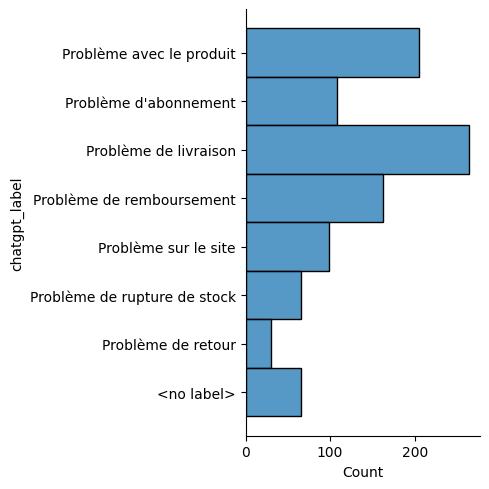

In [125]:
#import pandas as pd
#from itables import show
#import ast
#import numpy as np

df = pd.read_csv('../data/chatgpt_labelled_reviews_1000/edited.csv')
df = df.drop(["prompt tokens","completion tokens", "hallucinated labels count", "human checked ?", "id", "star"],axis=1)
df = df.dropna(axis=0)
df['chatgpt_label'] = df['chatgpt_label'].apply(lambda x: ast.literal_eval(x)[0] if len(ast.literal_eval(x))>0 else np.nan)

print('shape: ', df.shape)
df.info()
display(df['chatgpt_label'].value_counts())
display(df['chatgpt_label'].value_counts(normalize=True))
print('nb of review without label:', df['chatgpt_label'].isna().sum())

# reviews without label
display(df[df['chatgpt_label'].isna()])
df.loc[df['chatgpt_label'].isna(),'chatgpt_label'] = '<no label>'
display(df.loc[df['chatgpt_label']  == '<no label>'])

display(df.sample(25))

import seaborn as sns
sns.displot(y='chatgpt_label', data=df);

## save train test split

Afin de pouvoir comparer différents algorithmes - voir d'en combiner, il est judicieux de le faire avec les mêmes jeux de données, notemment pour éviter la contagion des données de test en faisant des train_test_split dans des fichiers différents. Ainsi, faisons un split que nous allons sauvegarder pour pouvoir le réutiliser dans les notebooks suivants.

In [126]:
from sklearn.model_selection import train_test_split


test_size = 0.2
random_state = 42
df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)

print(df_train.shape, df_test.shape)

(800, 5) (200, 5)


In [127]:
df_train.to_csv('../data/chatgpt_labelled_reviews_1000/train.csv')
df_test.to_csv('../data/chatgpt_labelled_reviews_1000/test.csv')


# TODO & improvements ideas
> - iterate on topics json (more or less exclusive etc...)
> - evaluations methods
>   - **distribution of labels**
>   - **evaluate with another prompt (ELO scores etc...)** https://github.com/mshumer/gpt-prompt-engineer/blob/main/gpt_prompt_engineer.ipynb
>   - compare to gold standard (the labels)
>   - compare to gold standard (the labels) via another prompt
> - iterate on prompt (some hallucinations on some topics ?)
> - play with openAI settings
> https://platform.openai.com/docs/guides/text-generation/faq
>    - use JSON mode ?
>    - use temperature ? 
>    - other model ?
> - use a local modal like w. Ollama ? --> probably take something of the order of ~12s per review --> hunderds of hours for 100k reviews https://github.com/ollama/ollama/blob/main/docs/api.md
